# Requirements to run

We recommend generatating a new Anaconda environment before trying to run this project.
The reason is that igraph may have dependencies that conflict with your other project configurations.
As a consequence a new Anaconda environment will likely lead to less debugging and conflicting package issues.

### If you miss a dependency
conda install -c conda-forge python-igraph <br/>
conda install -c conda-forge pycairo <br/>
conda install pandas

Note that the correct igraph package is listed at https://igraph.org/python/doc/tutorial/install.html and NOT at anaconda.org!

In [62]:
import pandas as pd
import json
from pandas.io.json import json_normalize
import igraph as igraph
import math
import numpy as np
import os as os
import csv
import random
import matplotlib.pyplot as plt

### Check igraph installation 
This is purely for ensuring the package has been installed correctly

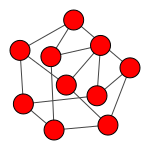

In [63]:
import igraph as ig
g = ig.Graph.Famous("petersen")
ig.plot(g, bbox=(0, 0, 150, 150))

# Notes on JSONs
33395: complexity outcome is more complicated due to text-icon split than with list item clickables due to how the interface has been defined. In reality there should be no complexity difference for the user. No action taken as of now. For this issue <br/>

In [64]:
verticesMap = {"Advertisement": "AD",
               "Background Image": "BI",
               "Button Bar": "BB", 
               "Checkbox": "C", 
               "Card": "CC",
               "Date Picker": "DP",
               "Icon": "I", 
               "Image": "IM", 
               "Input": "IP", 
               "List Item": "L", 
               "Map View": "M",
               "On/Off Switch": "S",
               "Pager Indicator": "P",
               "Radio Button": "RB", 
               "Text": "TC", 
               "Text Button": "TB", 
               "Web View": "WV"}

edgesMap = {"AD": "Tap",
            "BB": "Tap",
            "BI": "Tap",
            "C": "Tap", 
            "CC": "Tap",
            "DP": "Multi-tap",
            "I": "Tap", 
            "IM": "Tap", 
            "IP": "Multi-tap", 
            "L": "Tap", 
            "M": "Multi-mode",
            "P": "Swipe",
            "RB": "Tap", 
            "S": "Tap",
            "TB": "Tap", 
            "TC": "Tap", 
            "WV": "Tap"} 

doNotEndTask = ["Checkbox", "Date Picker", "Input", "On/Off Switch"]

## Extract components from file

In [65]:
def getNormalizedBounds(dimensions, bounds):
    x1 = bounds[0] / dimensions[2]
    y1 = bounds[1] / dimensions[3]
    x2 = bounds[2] / dimensions[2]
    y2 = bounds[3] / dimensions[3]
    return [x1, y1, x2, y2]

def sortControlComponents(components):
    sortedComponents = []
    for component in components:
        bounds = component[1]
        componentPosition = 0
        for i in range(len(sortedComponents)):
            compareTo = sortedComponents[i]
            compareToBounds = compareTo[1]
            #If the new component is below the previous one then we move 
            #it to towards the end of component ordering
            if bounds[1] > compareToBounds[3]:
                componentPosition += 1
            #if we have overlap between the components we choose by
            #the component ordering in horizontal plane
            elif bounds[0] > compareToBounds[2]:
                componentPosition += 1
            #otherwise we assume that the current component is before the other component
        sortedComponents.insert(componentPosition, component)
    return sortedComponents
        

def getControlComponents(children):
    controlComponents = []
    def loopForControlComponents(children):
        for c in children:
            clickable = c['clickable']
            if(clickable):
                controlComponents.append((clickable, c['bounds'], 
                                          c['componentLabel']))
            elif("children" in c):
                loopForControlComponents(c["children"])
                
    loopForControlComponents(children)
    ccCount = len(controlComponents)
    return controlComponents, ccCount

## Define Matrix Structure
The matrix is defined as such that any connection flowing downwards from a node above is marked in the matrix row that defines the node existing underneat it with a value 1. In other words if the first node flows to the leftmost node below it from the left we have a matrix:<br/>
[[0,0,0],<br/>
 [1,0,0],<br/>
 [0,0,0]]<br/>
 In the above definition one node is not connected to anything.
 If node on second level had a connection to two other nodes underneath it we would define the matrix as:<br/>
 [[0,0,0,0],<br/>
  [1,0,0,0],<br/>
  [0,1,0,0],<br/>
  [0,1,0,0]]<br/>

In [66]:
def defineAdjacencyMatrix(controlComponents, ccCount): 
    adjacencyMatrix =  [[0] * (ccCount+2)]
    endVector = [0] * (ccCount+2) 
    endpointsCounter = ccCount
    #this defines where the next nodes shall form connections
    currentAnchorColumn = 0
    componentLimit = ccCount - 1
    for i in range(ccCount): 
            component = controlComponents[i]
            intermediateVector = []
            
            #special case for filling a login code with automatic UI refresh 
            #when Input field meets required length
            if(component[2] in doNotEndTask and i == componentLimit):
                intermediateVector = [0] * (ccCount+1)
                intermediateVector.insert(currentAnchorColumn, 1)
                currentAnchorColumn = 0
                endVector[i+1] = 1
            elif(component[2] in doNotEndTask):
                intermediateVector = [0] * (ccCount+1) 
                intermediateVector.insert(currentAnchorColumn, 1) 
                currentAnchorColumn = i + 1
                endVector[i+1] = 0
                endpointsCounter -= 1
            else:
                intermediateVector = [0] * (ccCount+1)
                intermediateVector.insert(currentAnchorColumn, 1)
                currentAnchorColumn = 0
                endVector[i+1] = 1
            adjacencyMatrix = adjacencyMatrix + [intermediateVector] 
            #endVector[id+1] = 1
    adjacencyMatrix = adjacencyMatrix + [endVector] 
    return np.array(adjacencyMatrix), endpointsCounter


def defineVertices(adjacencyMatrix, controlComponents): 
    verticeLabels = ["E"] 
    noEndpoints = pd.DataFrame(adjacencyMatrix)
    noEndpoints.drop(0,inplace=True)
    noEndpoints.drop(noEndpoints.tail(1).index,inplace=True)
    layersWithVertices = noEndpoints.sum(axis=0) 
    layersWithVertices = layersWithVertices[layersWithVertices != 0]
    columnsWithVerticesIndexes = layersWithVertices.index
    currentComponentItem = 0
    for i in columnsWithVerticesIndexes:
        currentColumn = adjacencyMatrix[:, i]
        for row, c in enumerate(currentColumn):
            if c == 1:
                currentItem = controlComponents[currentComponentItem][2]
                #These form the base level of the graph and other components are inserted around these
                #to match the order required by igraph
                if(i == 0):
                    verticeLabels.append(verticesMap[currentItem])
                else:
                    verticeLabels.insert(row-1, verticesMap[currentItem])
                currentComponentItem += 1

    verticeLabels = verticeLabels + ["S"] 
    return verticeLabels 

def defineEdges(adjacencyMatrix, verticeLabels, endpointCount):
    edgeLabels = []
    workedThroughGroupItems = 0
    for v in range(len(verticeLabels)-1):
        if(verticeLabels[v] in edgesMap):   
            edgeLabels = edgeLabels + [edgesMap[verticeLabels[v]]]
        elif(verticeLabels[v] == "E"):
            edgeLabels = (["O"]*endpointCount) + edgeLabels

    return edgeLabels

## Complexity Computations

In [67]:
def computeHalstead(edgeLabels, verticeLabels):
    #number of unique operators
    n1 = len(set(edgeLabels))
    #number of unique operands. We remove start and end
    n2 = len(set(verticeLabels))-2
    #total frequency of operators
    N1 = len(edgeLabels)
    #total frequency of operands. We remote start and end 
    N2 = len(verticeLabels)-2
    
    firstPart = (n1*N2*(N1+N2))/(2*n2)
    logPart = math.log(n1+n2, 2)
    #rounded to S significant numbers
    return round(firstPart*logPart,3)

#we have omitted McCabe from this work due to difficulties with scaling
#McCabe might be a suitable measure in other contexts
def computeMcCabeVG(adjacencyMatrix):
    nodes = len(adjacencyMatrix)
    edges = adjacencyMatrix.sum().sum()
    return nodes - edges

#This is the Shannon Entropy based ID measure
def indexOfDifficulty(startPosition, targetComponent):
    W = 0
    startX = (startPosition[2] - startPosition[0])/2 + startPosition[0]
    startY = (startPosition[3] - startPosition[1])/2 + startPosition[1]
    targetWidth = targetComponent[2] - targetComponent[0]
    targetHeight = targetComponent[3] - targetComponent[1]
    targetXCenter = targetWidth / 2 + targetComponent[0]
    targetYCenter = targetHeight / 2 + targetComponent[1]
    
    if(targetWidth < targetHeight):
        W = targetWidth
    else:
        W = targetHeight
    A = math.sqrt(math.pow(targetXCenter - startX, 2) + math.pow(targetYCenter - startY, 2))
    ID = math.log(A/W+1,2)
    return ID

#called from computeWoodEntropy()
def woodCoordinativeComplexity(adjacencyMatrix, sortedControlComponents, screenDimensions):
    precedenceRelations = 0
    for i in range(len(sortedControlComponents)):
        cursor = i + 1
        currentAdjacencyRow = adjacencyMatrix[cursor]
        currentComponentIndex = np.where(currentAdjacencyRow==1)[0][0]
        if(currentComponentIndex == 0):
            continue
        while(currentComponentIndex > 0):
            precedenceRelations += 1
            cursor -= 1
            currentAdjacencyRow = adjacencyMatrix[cursor]
            currentComponentIndex = np.where(currentAdjacencyRow==1)[0][0]
            
        #print("start component index", startComponentIndex)
        #startComponent = []
        #if(startComponentIndex == 0):
           # startComponent = screenDimensions
        #else:
            #startComponent = sortedControlComponents[startComponentIndex-1][1]
        #difficultySum += indexOfDifficulty(startComponent, sortedControlComponents[i][1])
        
    return precedenceRelations

def woodComponentComplexity(verticeLabels):
    verticesCount = len(verticeLabels)-2
    return verticesCount

def computeWoodEntropy(adjacencyMatrix, sortedControlComponents, screenDimensions, verticeLabels):
    coordinativeComplexity = woodCoordinativeComplexity(adjacencyMatrix, sortedControlComponents, screenDimensions)
    componentComplexity = woodComponentComplexity(verticeLabels)
    return coordinativeComplexity, componentComplexity

## Task Performance Computation

We employ a classic choice-reaction experiment where the user is familar with the tasks on the interface and has to perform the specified one. This type of experiment models the choice-reaction time using the Hick-Hymabn law while the pointing time is based on Fitts' law with parameters based on a touch screen case study

In [86]:
a_tap = 52.12
b_tap = 14.62
choice_time = 1350
#a_swipe = 9.46
#b_swipe = 55.83
swipe = 70

In [88]:
def fitts(currentComponent, screenDimensions, edgeLabel):
    difficulty = indexOfDifficulty(screenDimensions, currentComponent)
    tap = a_tap + b_tap * difficulty
    if(edgeLabel == "Tap"):
        return tap
    else:
        return tap + swipe

#def hicks(edgeLabels):
#    choices = len(edgeLabels) - 2
#    choiceReaction = b_hick * math.log(choices+1,2)
#    return choiceReaction

def KLM(sortedControlComponents, screenDimensions, edgeLabels):
    totalTime = 0
    for i in range(len(sortedControlComponents)):
        totalTime += choice_time
        totalTime += fitts(sortedControlComponents[i][1], screenDimensions, edgeLabels[i+1])
    return round(totalTime/1000, 2)
        

## Call function and visualization

In [69]:
def getFile(fileName):
    with open("hierarchies/"+fileName, encoding="utf-8") as f:
        data = json.load(f)
        dimensions = data['bounds']
        children = data['children']
        return dimensions, children

def visualizeMatrix(adjacencyMatrix, verticeLabels, edgeLabels, fileName, manualTest=False):
    directed = ig.Graph.Adjacency(adjacencyMatrix, mode="directed") 
    directed.vs["label"] = verticeLabels
    directed.vs["color"] = "white"
    directed.es["label"] = edgeLabels
    #directed.es["curved"] = seq(-0.5, 0.5, length = ecount(directed))
    directed.es["curved"] = False
    layout = directed.layout("rt")
    #save to file
    #return as a plot for a jupyter cell
    if(manualTest == True):
        return ig.plot(directed,  layout=layout, bbox=(0, 0, 350, 350), margin=20)
    
    ig.plot(directed, "graphs/"+fileName[:-5]+".png", layout=layout, bbox=(0, 0, 800, 800), margin=20)
    return
 

def determineControlGraphForFile(file):
    screenDimensions, children = getFile(file)
    controlComponents, ccCount = getControlComponents(children)
    #we need to sort control components as they are not always
    #in a sensible order from the perspective of how the actions would be performed
    sortedControlComponents = sortControlComponents(controlComponents)
    adjacencyMatrix, endpointCount = defineAdjacencyMatrix(sortedControlComponents, ccCount)
    verticeLabels = defineVertices(adjacencyMatrix, sortedControlComponents)
    edgeLabels = defineEdges(adjacencyMatrix, verticeLabels, endpointCount)

    #complexity computation
    halstead = computeHalstead(edgeLabels, verticeLabels)
    #mcCabe = computeMcCabeVG(adjacencyMatrix)
    woodCoordinative, woodComponent = computeWoodEntropy(
        adjacencyMatrix, sortedControlComponents, screenDimensions, verticeLabels)
    if(("Multi-tap" in edgeLabels) or ("Multi-mode" in edgeLabels)):
        #print("Halstead", halstead, "McCabe", mcCabe, "Wood coordinative", woodCoordinative, 
          #"Wood component", woodComponent, "Wood total", round(woodCoordinative+woodComponent,2))
        return [file, adjacencyMatrix, verticeLabels, edgeLabels, halstead,woodCoordinative, woodComponent, 0]
    else:
        taskTime = KLM(sortedControlComponents, screenDimensions, edgeLabels)
        print("Task time", taskTime)
        return [file, adjacencyMatrix, verticeLabels, edgeLabels, halstead,
                woodCoordinative, woodComponent, taskTime]

## Generate graphs for all json files

In [70]:
def listAllFiles(folderPath):
    return os.listdir(folderPath)

def writeAnalyticsDataToFile(graphArrays):
    header = ['id', 'halstead', 'coordinative', 'component', 'wood', 'wood_sqrt', "taskTime", 'paths', 'components']
    with open('./analytics.csv', 'w', encoding='UTF8', newline="") as f:
        writer = csv.writer(f)
        writer.writerow(header)
        print("arrayslen", len(graphArrays))
        print("first array", graphArrays[0])
        for graphArray in graphArrays:
            paths = 0
            for row in graphArray[1]:
                if row[0] == 1:
                    paths +=1
            #file = graphArray[0]
            wood = graphArray[5]+graphArray[6]
            rowToWrite = [graphArray[0], graphArray[4], graphArray[5], graphArray[6], 
                         round(wood,2), round(math.sqrt(wood),2),  graphArray[7], paths, len(graphArray[2])-2]
            writer.writerow(rowToWrite)
        
def writeErrorsDataToFile(errors):
    with open('.errors.csv', 'w', encoding='UTF8', newline="") as f:
        writer = csv.writer(f)
        writer.writerow(['file', 'error'])
        writer.writerows(errors)
    

def loopAllJsonFiles(folderPath):
    allFiles = listAllFiles(folderPath)
    csvAnalytics = []
    errors = []
    for f in allFiles:
        try:
            controlGraphArray = determineControlGraphForFile(f)
            csvAnalytics.append(controlGraphArray)
            visualizeMatrix(controlGraphArray[1], controlGraphArray[2], controlGraphArray[3], f)
        except  Exception as e:
            errors.append([f, e])
            continue
    writeAnalyticsDataToFile(csvAnalytics)
    writeErrorsDataToFile(errors)

In [89]:
loopAllJsonFiles("hierarchies")

Task time 2.96
Task time 7.54
Task time 2.92
Task time 8.99
Task time 2.9
Task time 13.52
Task time 12.07
Task time 10.4
Task time 7.41
Task time 17.93
Task time 21.01
Task time 7.46
Task time 7.46
Task time 23.93
Task time 2.95
Task time 17.88
Task time 13.57
Task time 2.94
Task time 10.52
Task time 11.88
Task time 11.94
Task time 7.47
Task time 6.0
Task time 4.43
Task time 1.45
Task time 7.5
Task time 5.94
Task time 4.44
Task time 22.4
Task time 2.96
Task time 5.95
Task time 23.86
Task time 13.53
Task time 1.43
Task time 4.43
Task time 10.4
Task time 4.48
Task time 5.99
Task time 1.44
Task time 13.49
Task time 2.96
Task time 2.95
Task time 5.91
Task time 5.97
Task time 1.44
Task time 14.91
Task time 10.45
Task time 5.99
Task time 4.47
Task time 2.97
Task time 24.01
Task time 8.9
Task time 4.45
Task time 6.0
Task time 10.55
Task time 5.99
Task time 5.94
Task time 1.44
Task time 8.9
Task time 5.92
Task time 4.48
Task time 7.45
Task time 1.44
Task time 10.57
Task time 17.96
Task time 10

Task time 2.96
Task time 4.42
Task time 48.1
Task time 4.48
Task time 4.4
Task time 1.43
Task time 2.96
Task time 20.96
Task time 5.95
Task time 7.44
Task time 1.44
Task time 20.96
Task time 4.42
Task time 7.5
Task time 1.44
Task time 4.47
Task time 11.99
Task time 6.07
Task time 2.93
Task time 7.5
Task time 28.47
Task time 18.05
Task time 4.41
Task time 9.03
Task time 7.39
Task time 8.91
Task time 1.41
Task time 17.85
Task time 5.98
Task time 2.94
Task time 10.38
Task time 1.44
Task time 12.0
Task time 4.44
Task time 36.3
Task time 5.97
Task time 2.96
Task time 2.97
Task time 4.48
Task time 2.96
Task time 4.48
Task time 17.92
Task time 1.43
Task time 14.99
Task time 8.99
Task time 12.02
Task time 23.9
Task time 19.51
Task time 13.4
Task time 14.92
Task time 8.88
Task time 2.91
Task time 4.45
Task time 13.33
Task time 1.44
Task time 12.0
Task time 1.43
Task time 20.98
Task time 4.41
Task time 2.96
Task time 5.96
Task time 4.46
Task time 7.53
Task time 1.44
Task time 5.97
Task time 4.43

Task time 4.41
Task time 1.4
Task time 1.42
Task time 10.45
Task time 2.96
Task time 13.43
Task time 19.65
Task time 10.45
Task time 13.48
Task time 8.97
Task time 13.48
Task time 1.44
Task time 7.52
Task time 7.41
Task time 14.99
Task time 1.44
Task time 1.4
Task time 2.92
Task time 12.04
Task time 1.42
Task time 16.62
Task time 2.94
Task time 2.96
Task time 4.48
Task time 2.94
arrayslen 1390
first array ['10128.json', array([[0, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [0, 1, 1, 0]]), ['E', 'I', 'I', 'S'], ['O', 'O', 'Tap', 'Tap'], 19.02, 0, 2, 2.96]


# Visualization of results

In [90]:
results = pd.read_csv('analytics.csv')
print(results)

              id  halstead  coordinative  component  wood  wood_sqrt  \
0     10128.json    19.020             0          2     2       1.41   
1     10180.json    58.048             0          5     5       2.24   
2     10183.json    12.000             0          2     2       1.41   
3     10208.json    83.589             0          6     6       2.45   
4     10214.json    19.020             0          2     2       1.41   
...          ...       ...           ...        ...   ...        ...   
1385   9735.json   280.953             0         11    11       3.32   
1386   9827.json    19.020             0          2     2       1.41   
1387   9828.json    19.020             0          2     2       1.41   
1388   9895.json    42.794             0          3     3       1.73   
1389   9910.json    19.020             0          2     2       1.41   

      taskTime  paths  components  
0         2.96      2           2  
1         7.54      5           5  
2         2.92      2      

### Halstead Visualization

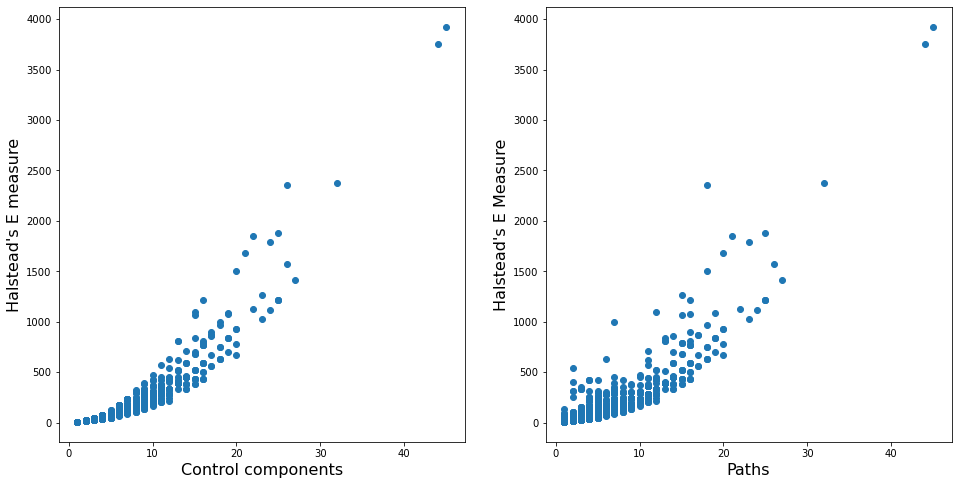

In [91]:
plt.figure(1, figsize=(16, 8))
plt.subplot(1,2,1)
plt.scatter(results['components'], results['halstead'])
plt.xlabel("Control components", fontsize=16)
plt.ylabel("Halstead's E measure", fontsize=16)
plt.subplot(1,2,2)
plt.scatter(results['paths'], results['halstead'])
plt.xlabel("Paths", fontsize=16)
plt.ylabel("Halstead's E Measure", fontsize=16)
plt.savefig('results/halstead-results.png')

## Wood Visualization

### Wood total, linear

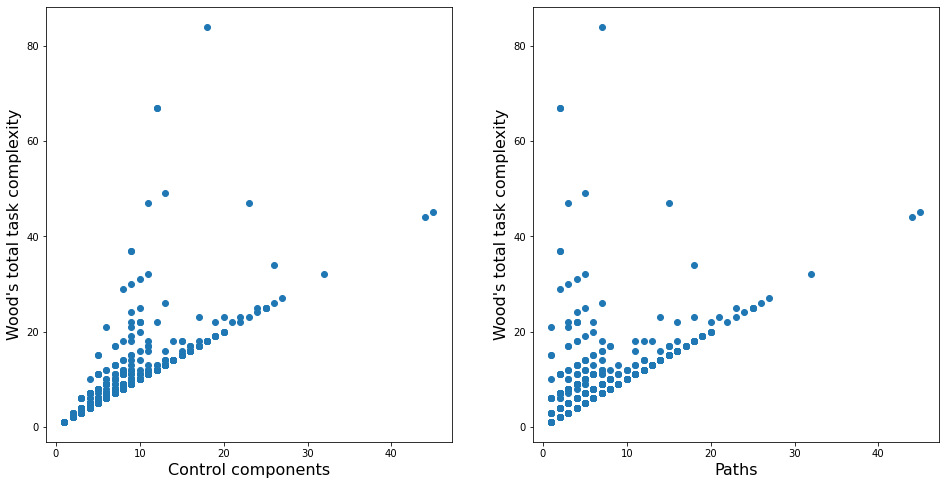

In [92]:
plt.figure(2, figsize=(16, 8))
plt.subplot(1,2,1)
plt.scatter(results['components'], results['wood'])
plt.xlabel("Control components", fontsize=16)
plt.ylabel("Wood's total task complexity", fontsize=16)
plt.subplot(1,2,2)
plt.scatter(results['paths'], results['wood'])
plt.xlabel("Paths", fontsize=16)
plt.ylabel("Wood's total task complexity", fontsize=16)
plt.savefig('results/wood-total-linear.png')

### Wood Square Root

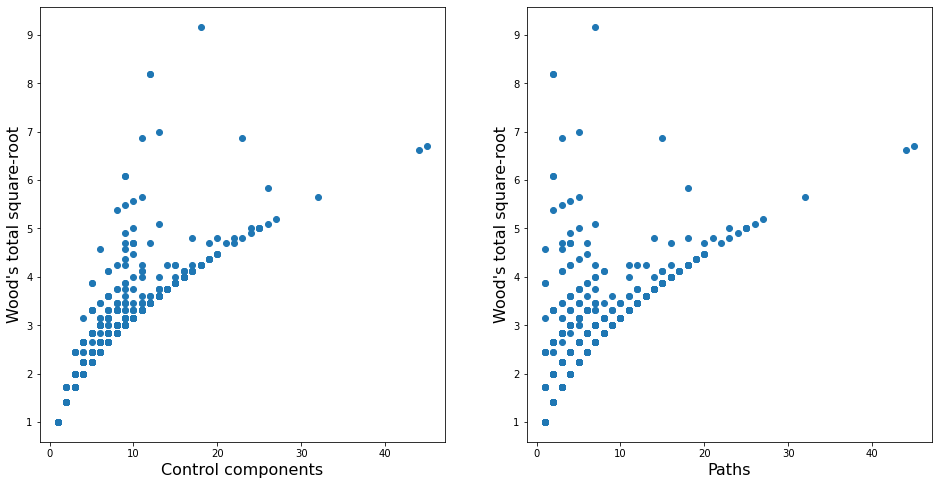

In [93]:
plt.figure(2, figsize=(16, 8))
plt.subplot(1,2,1)
plt.scatter(results['components'], results['wood_sqrt'])
plt.xlabel("Control components", fontsize=16)
plt.ylabel("Wood's total square-root", fontsize=16)
plt.subplot(1,2,2)
plt.scatter(results['paths'], results['wood_sqrt'])
plt.xlabel("Paths", fontsize=16)
plt.ylabel("Wood's total square-root", fontsize=16)
plt.savefig('results/wood-total-sqrt.png')

### Wood Coordinative

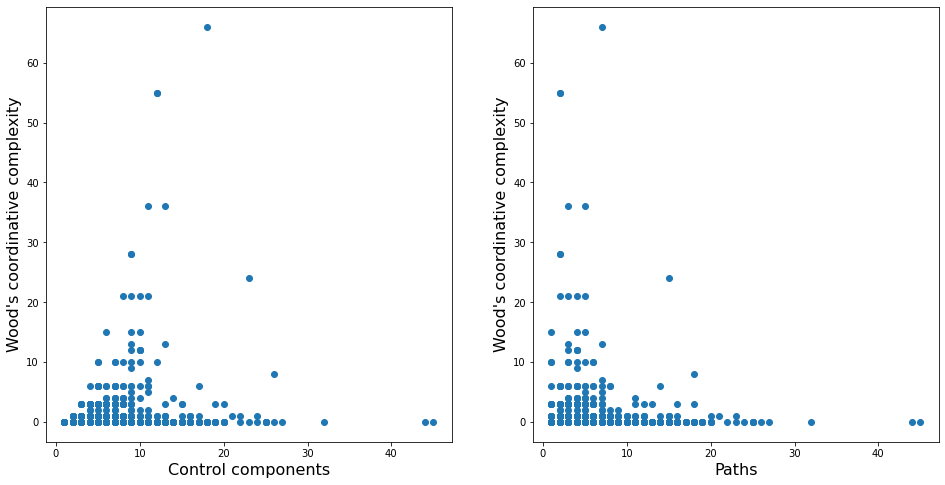

In [94]:
plt.figure(2, figsize=(16, 8))
plt.subplot(1,2,1)
plt.scatter(results['components'], results['coordinative'])
plt.xlabel("Control components", fontsize=16)
plt.ylabel("Wood's coordinative complexity", fontsize=16)
plt.subplot(1,2,2)
plt.scatter(results['paths'], results['coordinative'])
plt.xlabel("Paths", fontsize=16)
plt.ylabel("Wood's coordinative complexity", fontsize=16)
plt.savefig('results/wood-coordinative.png')

### Wood Component

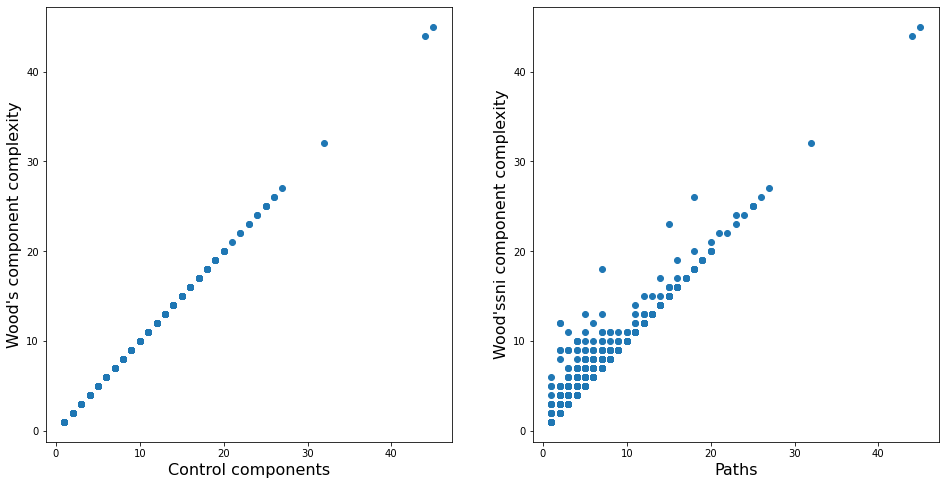

In [95]:
plt.figure(2, figsize=(16, 8))
plt.subplot(1,2,1)
plt.scatter(results['components'], results['component'])
plt.xlabel("Control components", fontsize=16)
plt.ylabel("Wood's component complexity", fontsize=16)
plt.subplot(1,2,2)
plt.scatter(results['paths'], results['component'])
plt.xlabel("Paths", fontsize=16)
plt.ylabel("Wood'ssni component complexity", fontsize=16)
plt.savefig('results/wood-component.png')

### Task time

In [96]:
results.head(30)

,id,halstead,coordinative,component,wood,wood_sqrt,taskTime,paths,components
0,10128.json,19.020,0,2,2,1.41,2.96,2,2
1,10180.json,58.048,0,5,5,2.24,7.54,5,5
2,10183.json,12.000,0,2,2,1.41,2.92,2,2
3,10208.json,83.589,0,6,6,2.45,8.99,6,6
4,10214.json,19.020,0,2,2,1.41,2.90,2,2
5,1028.json,243.000,0,9,9,3.00,13.52,9,9
6,10304.json,329.133,12,9,21,4.58,0.00,3,9
7,10352.json,148.603,0,8,8,2.83,12.07,8,8
8,10440.json,320.426,1,8,9,3.00,0.00,7,8
9,10482.json,20.897,0,2,2,1.41,0.00,2,2


In [97]:
tf = results.copy()

In [98]:
tf.drop(tf[tf['taskTime'] == 0].index, inplace = True)

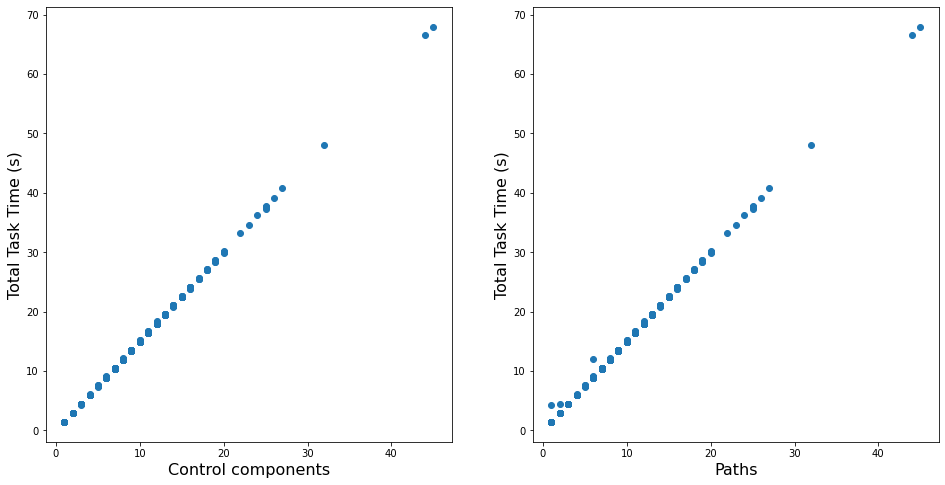

In [99]:
plt.figure(2, figsize=(16, 8))
plt.subplot(1,2,1)
plt.scatter(tf['components'], tf['taskTime'])
plt.xlabel("Control components", fontsize=16)
plt.ylabel("Total Task Time (s)", fontsize=16)
plt.subplot(1,2,2)
plt.scatter(tf['paths'], tf['taskTime'])
plt.xlabel("Paths", fontsize=16)
plt.ylabel("Total Task Time (s)", fontsize=16)
plt.savefig('results/task-time.png')

### Complexities VS Task Time

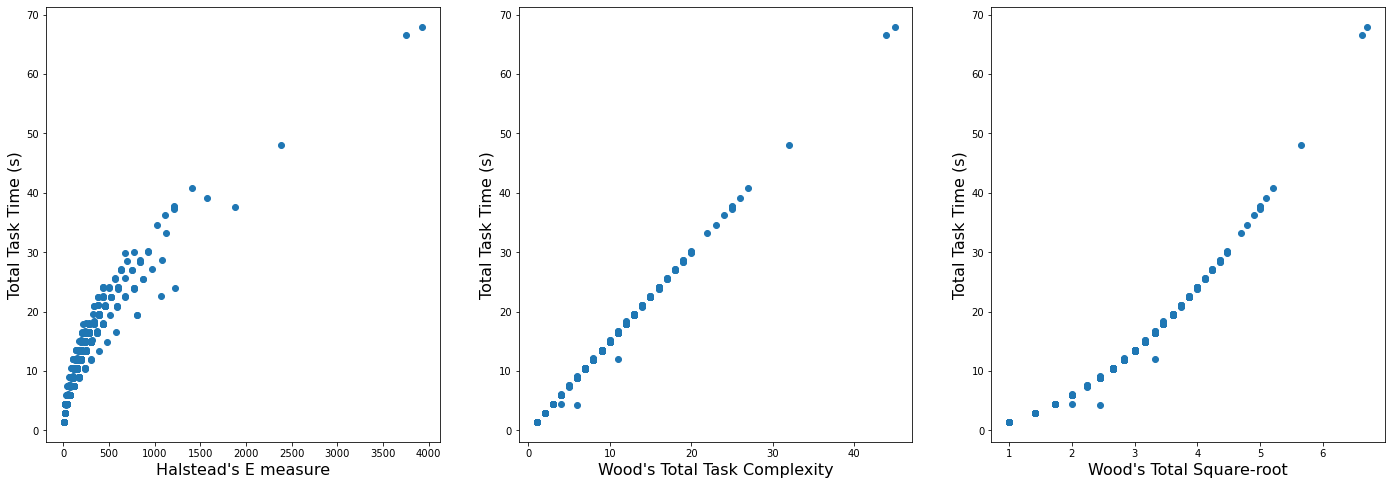

In [100]:
plt.figure(2, figsize=(24, 8))
plt.subplot(1,3,1)
plt.scatter(tf['halstead'], tf['taskTime'])
plt.xlabel("Halstead's E measure", fontsize=16)
plt.ylabel("Total Task Time (s)", fontsize=16)
#
plt.subplot(1,3,2)
plt.scatter(tf['wood'], tf['taskTime'])
plt.xlabel("Wood's Total Task Complexity", fontsize=16)
plt.ylabel("Total Task Time (s)", fontsize=16)
#
plt.subplot(1,3,3)
plt.scatter(tf['wood_sqrt'], tf['taskTime'])
plt.xlabel("Wood's Total Square-root", fontsize=16)
plt.ylabel("Total Task Time (s)", fontsize=16)
plt.savefig('results/complexity-time.png')

In [85]:
from sklearn import linear_model
regr1 = linear_model.LinearRegression()
regr.fit(tf['halstead'], tf['taskTime'])
regr2 = linear_model.LinearRegression()
regr.fit(tf['wood'], tf['taskTime'])
regr3 = linear_model.LinearRegression()
regr.fit(tf['wood_sqrt'], tf['taskTime'])
y1_pred = regr1.predict(tf['halstead'])
y2_pred = regr2.predict(tf['wood'])
y3_pred = regr3.predict(tf['wood_sqrt'])

ModuleNotFoundError: No module named 'sklearn'

In [ ]:
plt.subplot(1,3,1)
plt.scatter(tf['halstead'], tf['taskTime'])
plt.xlabel("Halstead's E measure", fontsize=16)
plt.ylabel("Total Task Time (ms)", fontsize=16)
#
plt.subplot(1,3,2)
plt.scatter(tf['wood'], tf['taskTime'])
plt.xlabel("Wood's Total Task Complexity", fontsize=16)
plt.ylabel("Total Task Time (ms)", fontsize=16)
#
plt.subplot(1,3,3)
plt.scatter(tf['wood_sqrt'], tf['taskTime'])
plt.xlabel("Wood's Total Square-root", fontsize=16)
plt.ylabel("Total Task Time (ms)", fontsize=16)
plt.savefig('results/complexity-time.png')

In [83]:
tf_corr = tf[['taskTime', 'halstead', 'wood', 'wood_sqrt']].copy()
tf_corr.corr()

,taskTime,halstead,wood,wood_sqrt
taskTime,1.000000,0.889828,0.997118,0.961986
halstead,0.889828,1.000000,0.887005,0.763628
wood,0.997118,0.887005,1.000000,0.967342
wood_sqrt,0.961986,0.763628,0.967342,1.000000


# Random sampling for code quality testing

In [ ]:
reRun = False
if reRun == False:
    raise Exception("Don't rerun the code block below by accident")

In [ ]:
 #this is set to false so we don't accidentally reset the sample
def randomSampleForQA(checkFolder):
    if reRun == True:
        allFiles = listAllFiles(checkFolder)
        sample = random.sample(allFiles, k=30)
        for s in sample:
            print(s)
    
randomSampleForQA('screenshots')

# Manual Test Section To Improve Code

precedence relations 4
[[0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0]
 [0 1 1 0 1 1 1 1 0 0 1 0]]
vertice labels
 ['E', 'I', 'I', 'IP', 'IP', 'IM', 'IM', 'TB', 'IP', 'WV', 'TB', 'S']
edge labels
 ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'Tap', 'Tap', 'Multi-tap', 'Multi-tap', 'Tap', 'Tap', 'Tap', 'Multi-tap', 'Tap', 'Tap']


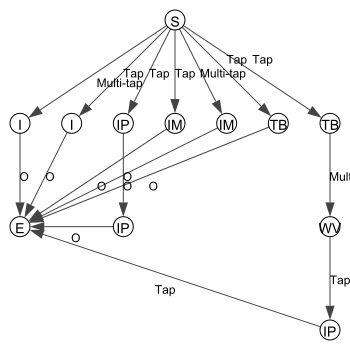

In [60]:
fileName = "124.json"
controlGraphArray = determineControlGraphForFile(fileName)
print(controlGraphArray[1])
print("vertice labels\n", controlGraphArray[2])
print("edge labels\n", controlGraphArray[3])
visualizeMatrix(controlGraphArray[1], controlGraphArray[2], controlGraphArray[3], fileName, True)

### ID 1074

precedence relations 1
[[0 0 0 0 0 0]
 [1 0 0 0 0 0]
 [1 0 0 0 0 0]
 [0 0 1 0 0 0]
 [1 0 0 0 0 0]
 [0 1 0 1 1 0]]
vertice labels
 ['E', 'I', 'TB', 'IP', 'TB', 'S']
edge labels
 ['O', 'O', 'O', 'Tap', 'Tap', 'Multi-tap', 'Tap']


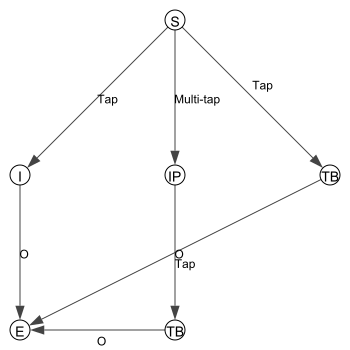

In [61]:
fileName = "1074.json"
controlGraphArray = determineControlGraphForFile(fileName)
print(controlGraphArray[1])
print("vertice labels\n", controlGraphArray[2])
print("edge labels\n", controlGraphArray[3])
visualizeMatrix(controlGraphArray[1], controlGraphArray[2], controlGraphArray[3], fileName, True)

### ID 44719

In [ ]:
fileName = "44719.json"
controlGraphArray = determineControlGraphForFile(fileName)
print("vertice labels\n", controlGraphArray[2])
print("edge labels\n", controlGraphArray[3])
visualizeMatrix(controlGraphArray[1], controlGraphArray[2], controlGraphArray[3], fileName, True)

### ID 44718

In [ ]:
fileName = "44718.json"
adjacencyMatrix, verticeLabels, edgeLabels = determineControlGraphForFile(fileName)
print(verticeLabels)
print(edgeLabels)
visualizeMatrix(adjacencyMatrix, verticeLabels, edgeLabels, fileName, True)

### Id 44706

In [ ]:
fileName = "44706.json"
adjacencyMatrix, verticeLabels, edgeLabels = determineControlGraphForFile(fileName)
print(verticeLabels)
print(edgeLabels)
visualizeMatrix(adjacencyMatrix, verticeLabels, edgeLabels, fileName, True)

### Id 41937

In [ ]:
fileName = "41937.json"
adjacencyMatrix, verticeLabels, edgeLabels = determineControlGraphForFile(fileName)
print(verticeLabels)
print(edgeLabels)
visualizeMatrix(adjacencyMatrix, verticeLabels, edgeLabels, fileName, True)

### ID 39118

In [ ]:
fileName = "39118.json"
adjacencyMatrix, verticeLabels, edgeLabels = determineControlGraphForFile(fileName)
print(verticeLabels)
print(edgeLabels)
visualizeMatrix(adjacencyMatrix, verticeLabels, edgeLabels, fileName, True)

### ID 37073

In [ ]:
fileName = "37073.json"
adjacencyMatrix, verticeLabels, edgeLabels = determineControlGraphForFile(fileName)
print(verticeLabels)
print(edgeLabels)
visualizeMatrix(adjacencyMatrix, verticeLabels, edgeLabels, fileName, True)

### ID 34595

In [ ]:
fileName = "34595.json"
adjacencyMatrix, verticeLabels, edgeLabels = determineControlGraphForFile(fileName)
print(verticeLabels)
print(edgeLabels)
visualizeMatrix(adjacencyMatrix, verticeLabels, edgeLabels, fileName, True)

### ID 23689

In [ ]:
fileName = "23689.json"
adjacencyMatrix, verticeLabels, edgeLabels = determineControlGraphForFile(fileName)
print(verticeLabels)
print(edgeLabels)
visualizeMatrix(adjacencyMatrix, verticeLabels, edgeLabels, fileName, True)

### ID 21545

In [ ]:
fileName = "21545.json"
adjacencyMatrix, verticeLabels, edgeLabels = determineControlGraphForFile(fileName)
print(verticeLabels)
print(edgeLabels)
visualizeMatrix(adjacencyMatrix, verticeLabels, edgeLabels, fileName, True)

### ID 20891 

In [ ]:
fileName = "20891.json"
adjacencyMatrix, verticeLabels, edgeLabels = determineControlGraphForFile(fileName)
print(verticeLabels)
print(edgeLabels)
visualizeMatrix(adjacencyMatrix, verticeLabels, edgeLabels, fileName, True)

### Id 1996
Outcome: deleted due to faulty json

In [ ]:
fileName = "1996.json"
adjacencyMatrix, verticeLabels, edgeLabels = determineControlGraphForFile(fileName)
print(verticeLabels)
print(edgeLabels)
visualizeMatrix(adjacencyMatrix, verticeLabels, edgeLabels, fileName, True)

### ID 17467

In [ ]:
fileName = "17467.json"
adjacencyMatrix, verticeLabels, edgeLabels = determineControlGraphForFile(fileName)
print(verticeLabels)
print(edgeLabels)
visualizeMatrix(adjacencyMatrix, verticeLabels, edgeLabels, fileName, True)

### ID 14310

In [ ]:
fileName = "14310.json"
adjacencyMatrix, verticeLabels, edgeLabels = determineControlGraphForFile(fileName)
print(verticeLabels)
print(edgeLabels)
visualizeMatrix(adjacencyMatrix, verticeLabels, edgeLabels, fileName, True)

### ID 10594

In [ ]:
fileName = "10594.json"
adjacencyMatrix, verticeLabels, edgeLabels = determineControlGraphForFile(fileName)
print(verticeLabels)
print(edgeLabels)
visualizeMatrix(adjacencyMatrix, verticeLabels, edgeLabels, fileName, True)

### ID 10482 computation

In [ ]:
fileName = "10482.json"
adjacencyMatrix, verticeLabels, edgeLabels = determineControlGraphForFile(fileName)
print(verticeLabels)
print(edgeLabels)
visualizeMatrix(adjacencyMatrix, verticeLabels, edgeLabels, fileName, True)

### ID 1809 computation

In [ ]:
fileName = "1809.json"
adjacencyMatrix, verticeLabels, edgeLabels = determineControlGraphForFile(fileName)
print(verticeLabels)
print(edgeLabels)
visualizeMatrix(adjacencyMatrix, verticeLabels, edgeLabels, fileName, True)

## Id 492 computation

In [ ]:
fileName = "492.json"
adjacencyMatrix, verticeLabels, edgeLabels = determineControlGraphForFile(fileName)
visualizeMatrix(adjacencyMatrix, verticeLabels, edgeLabels, fileName, True)

### Id 1863 computation

In [ ]:
fileName = "1863.json"
adjacencyMatrix, verticeLabels, edgeLabels = determineControlGraphForFile(fileName)
visualizeMatrix(adjacencyMatrix, verticeLabels, edgeLabels, fileName, True)

### Id 546 computation

In [ ]:
fileName = "546.json"
adjacencyMatrix, verticeLabels, edgeLabels = determineControlGraphForFile(fileName)
visualizeMatrix(adjacencyMatrix, verticeLabels, edgeLabels, fileName, True)

### Id 758 computation

In [ ]:
fileName = "758.json"
adjacencyMatrix, verticeLabels, edgeLabels = determineControlGraphForFile(fileName)
visualizeMatrix(adjacencyMatrix, verticeLabels, edgeLabels, fileName, True)

### Id 10596 computation

In [ ]:
fileName = "10596.json"
adjacencyMatrix, verticeLabels, edgeLabels = determineControlGraphForFile(fileName)
visualizeMatrix(adjacencyMatrix, verticeLabels, edgeLabels, fileName, True)

### Id 1074 Computation

In [ ]:
fileName = "1074.json"
adjacencyMatrix, verticeLabels, edgeLabels = determineControlGraphForFile(fileName)
visualizeMatrix(adjacencyMatrix, verticeLabels, edgeLabels, fileName, True)

# Old stuff, ignore - not relevant

## Edited JSON files
14310 reason: the text items here are clickable in reality, original version had false <br/>
21545 reason: components not set as  clickable correctly <br/>
23689 reason: pager indicator means there is a swipe component but rico didn't register it as clickable
27046 reason: incorrectly set drawer as clickable when list items are the clickables <br/>
30348 reason: incorrectly set drawer as clickable when list items are the clickables <br/>
33395 reason: clickable text and arrow icons were incorrectly marked to false <br/>
35472 reason: clickable list items were set to false <br/>
36000 reason: clickable text was set to false (looks like text button but might have borders on text element!) <br/>
36999 reason: toolbar was incorrectly set as clickable <br/>
39118 reason: list items incorrectly marked as unclickable <br/>
43387 reason: file download icon was not set as clickable <br/>
44706 reason: incorrect clickables due to Toolbar <br/>
46019 reason: modal text elements not marked as clickables <br/>

## Deleted UIs
1996: reason: faulty json missing component for "Home" <br/>
21186 reason: Too many components with clickable flag set incorrectly. <br/>
24701 reason: incorrect clickability labeling <br/>
26150 reason: no clickables set and UI too complicated to reliably mark correct clickables <br/>
26442 reason: too much speculation when determining swipe component <br/>
29058 reason: no proper indicator component for swipeability <br/>
34595 reason: seems to pick up item underneath the drawer <br/>
39015 reason: too much ambiquity with correcting incorrect clickable components <br/>
39334 reason: JSON doesn't match interaction graph structure as perceived by human <br/>
41679 reason: picked elements from underneath calculator widget. <br/>
44718 reason: picked elements from underneath toolbar <br/>

<br/>
11049 reason: charmaps to undefined, faulty coding (font not understood) <br/>
11148 reason: charmaps to undefined, faulty coding (font not understood) <br/>
11150 reason: charmaps to undefined, faulty coding (font not understood)